# Predicting Customer Satisfaction - Exploratory Data Analysis (EDA)

---

## Introduction

This exploratory data analysis (EDA) examines open-text reviews from Intel's call center surveys spanning 2018 to 2021. The study aims to predict callers' customer satisfaction by leveraging natural language processing techniques. Developing such a model can help Intel improve satisfaction scores and reduce future expenses associated with manual analysis. Moreover, this model may serve as a foundation for more advanced and effective analytical tools.

## Hypothesis for Call Center Customer Satisfaction Prediction

### Null Hypothesis (H₀)
There is no predictive relationship between Intel's call center customer reviews and customer satisfaction.

### Alternative Hypothesis (H₁)
There is a predictive relationship between Intel's call center customer reviews and customer satisfaction, meaning that call center reviews have a significant impact on predicting whether a customer is satisfied or not.

---

## Data Source and Methodology

- **Data Sources:**  
  The dataset is sourced from the Intel website surveys developed by ONR.
  
- **Methodology:**  
    This analysis utilizes **logistic regression** to evaluate the relationship between customer call center reviews and their effectiveness in predicting overall satisfaction.

---

## Practical Applications  

This analysis is particularly valuable for **call center managers and customer experience teams** looking to enhance service quality and customer satisfaction. It offers:  

- **Actionable Insights:** The classification model may identify key factors influencing customer satisfaction and areas for improvement.  
- **Strategic Guidance:** Provides a data-driven framework for optimizing call center operations, reducing churn, and improving overall service efficiency.

Table of Contents
=================

1. [Importing the Data](#Importing-the-Data)
2. [Data Preprocessing](#Data-Preprocessing)
3. [Data Exploration](#Data-Exploration)
   - [Word Frequency](#Word-Frequency)
   - [Review Length Analysis by Satisfaction Level](#Review-Length-Analysis-by-Satisfaction-Level)
   - [Review Length T-test](#Review-Length-T-test)
   - [Satisfaction Frequencies](#Satisfaction-Frequencies)

In [3]:
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import warnings
warnings.filterwarnings("ignore")

import os
import sys
import warnings
import numpy as np

from collections import Counter
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud

# Get the current working directory (the directory of the running script)
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, "NLP_Functions")))
from NLP_Functions.Preprocessing_Functions import Preprocessing, TextProcessingPipeline

sys.path.append(os.path.abspath(os.path.join(current_dir, "Classification_Functions")))
from Classification_Functions.Classification_Metrics_Functions import Metrics
from Classification_Functions.Preprocessing_Functions import Preprocessing

# Importing the Data

---

In [5]:
# Load dataset
columns_to_load = ['SAT','MTranslation2']
doc = pd.read_csv("Data/Intel_Website_Reviews_2018_2021.csv", usecols=columns_to_load, low_memory=False)
doc = doc.dropna(subset=["MTranslation2"])
doc = doc.dropna(subset=["SAT"])

doc.info()
doc.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 52385 entries, 0 to 52856
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   SAT            52385 non-null  object
 1   MTranslation2  52385 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


,SAT,MTranslation2
0,Satisfied,"they were persistent in achieving the task, wh..."
1,Satisfied,Hope to print After-sale service information o...
2,Satisfied,Our support staff was very courteous. The with...


# Data Preprocessing

---

## Text Processing Pipeline Overview

This text processing pipeline is designed to **clean, normalize, and preprocess text data** for **NLP applications**, particularly for customer reviews in a call center setting. Below is a breakdown of its key functionalities.

## Key Processing Steps

### 1. Text Cleaning 
- Removes **HTML tags, URLs, mentions (`@username`), and special characters**.
- Normalizes **repeated characters** (e.g., `"soooo"` → `"soo"`).
- Converts text to **lowercase** and removes **extra spaces**.

### 2. Stopword Removal 
- Removes common words (e.g., `"the"`, `"and"`, `"is"`) that do not add meaningful context.
- Uses a **custom stopword list** imported from `NLP_Functions.Stopwords_Loader`.

### 3. Lemmatization 
- Converts words to their **base form** (e.g., `"running"` → `"run"`).
- Uses **spaCy's NLP model** (`en_core_web_sm`).

### 4. Noise Removal 
- Filters out **unknown words** (words that are not recognized in the spell checker’s dictionary).
- Removes words that contain **numbers** (e.g., `"abc123"`).
- Eliminates **short words** (less than 3 characters).

## Pipeline Execution 
- This pipeline applies the above steps to a **Pandas DataFrame**.
- Users can enable or disable specific preprocessing steps via function arguments.
- The processed text is stored in a new column (`processed_{text_column}`).
- The pipeline also computes **text length** (word count) and filters out empty processed texts.

## Outcome
- Produces **cleaned, structured, and meaningful text data** for NLP tasks.
- Enhances **text classification model** by reducing noise and improving accuracy.
- Helps **identify key patterns** in customer satisfaction reviews.

This pipeline ensures that text data is **optimized for machine learning models** by reducing irrelevant content and standardizing textual features.


In [7]:
# Initialize pipeline
pipeline = TextProcessingPipeline(doc, text_column="MTranslation2")

# Run the pipeline
processed_df = pipeline.process()

processed_df.info()
processed_df.head(3)

Processing Text: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52385/52385 [1:04:51<00:00, 13.46it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51293 entries, 0 to 51292
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   SAT                      51293 non-null  object
 1   MTranslation2            51293 non-null  object
 2   processed_MTranslation2  51293 non-null  object
 3   review_length            51293 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.6+ MB


,SAT,MTranslation2,processed_MTranslation2,review_length
0,Satisfied,"they were persistent in achieving the task, wh...",persistent achieve task helpfuleven busy sched...,13
1,Satisfied,Hope to print After-sale service information o...,hope print aftersale service information product,6
2,Satisfied,Our support staff was very courteous. The with...,support staff courteous withdrawal defective o...,30


After the data cleaning process, certain words were removed as they were classified as either "noise" or stop words. As a result, some short or "spam-like" reviews were completely filtered out.

of the starting 52,385 reviews 1,092 reviews were removed leaving 51,293 to use in the analysis.

# Data Exploration

---

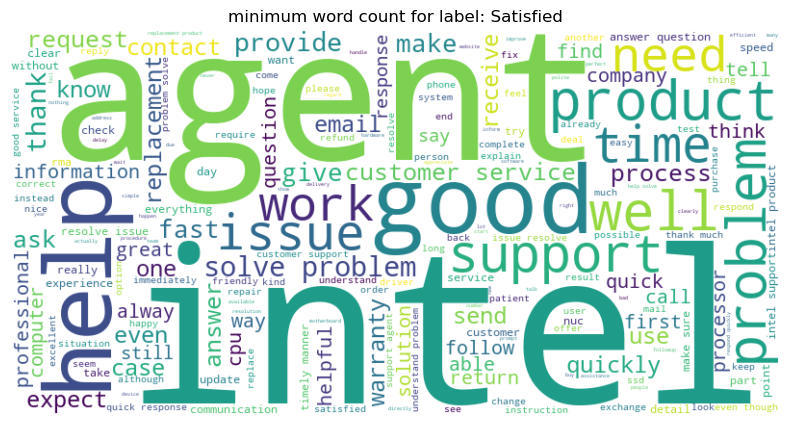

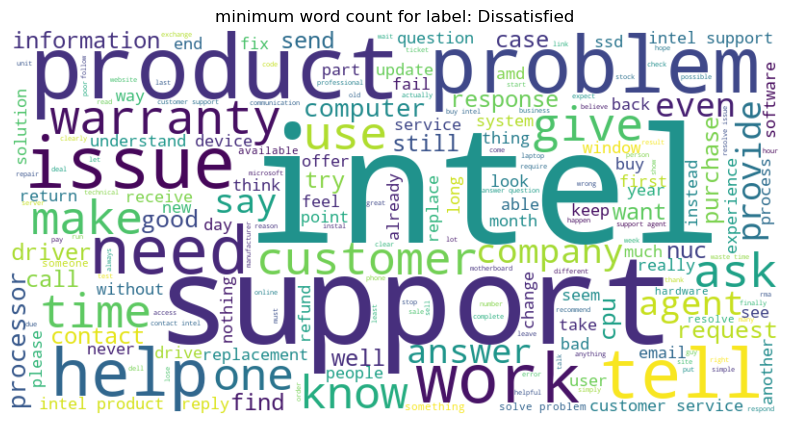

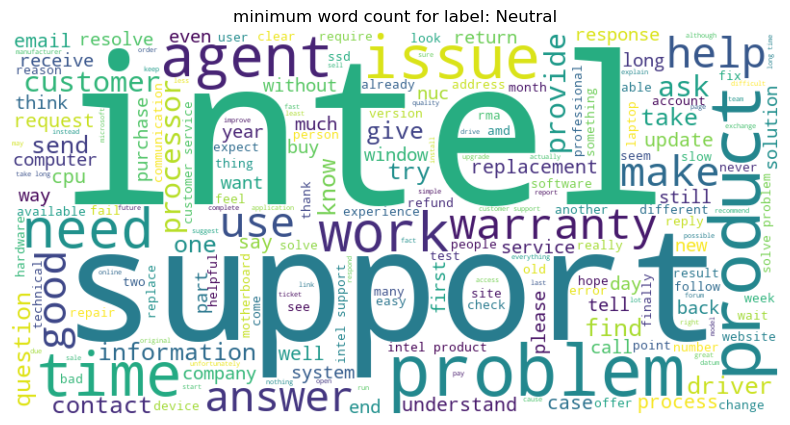

In [30]:
satification_list = processed_df['SAT'].unique()

for satisfaction in satification_list:
    sat_df = processed_df.loc[(processed_df['SAT'] == satisfaction)]
    text = " ".join(sat_df["processed_MTranslation2"])
    
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"minimum word count for label: {satisfaction}")
    plt.show()

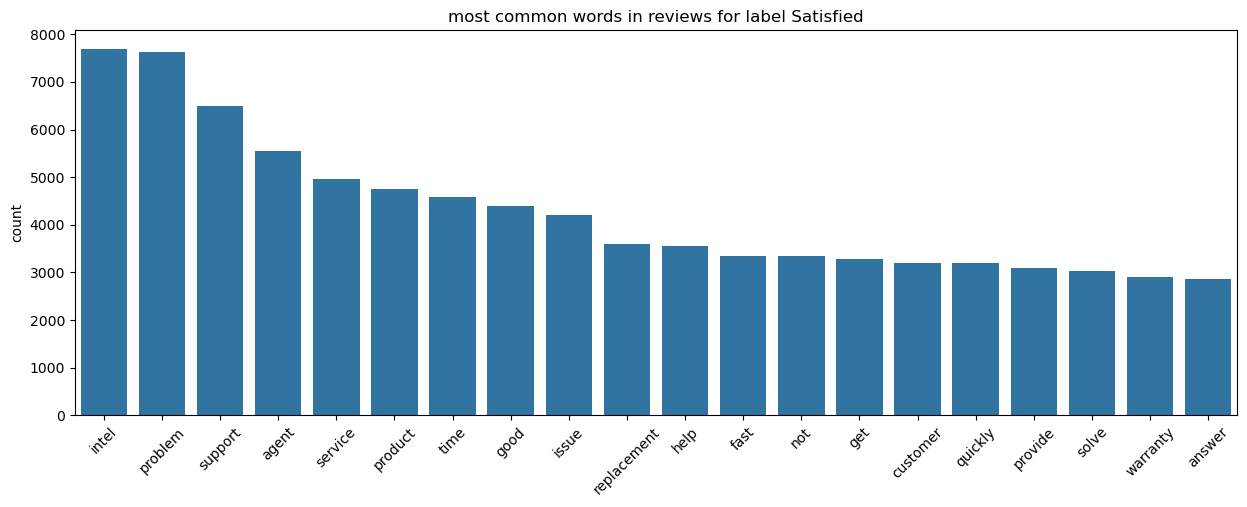

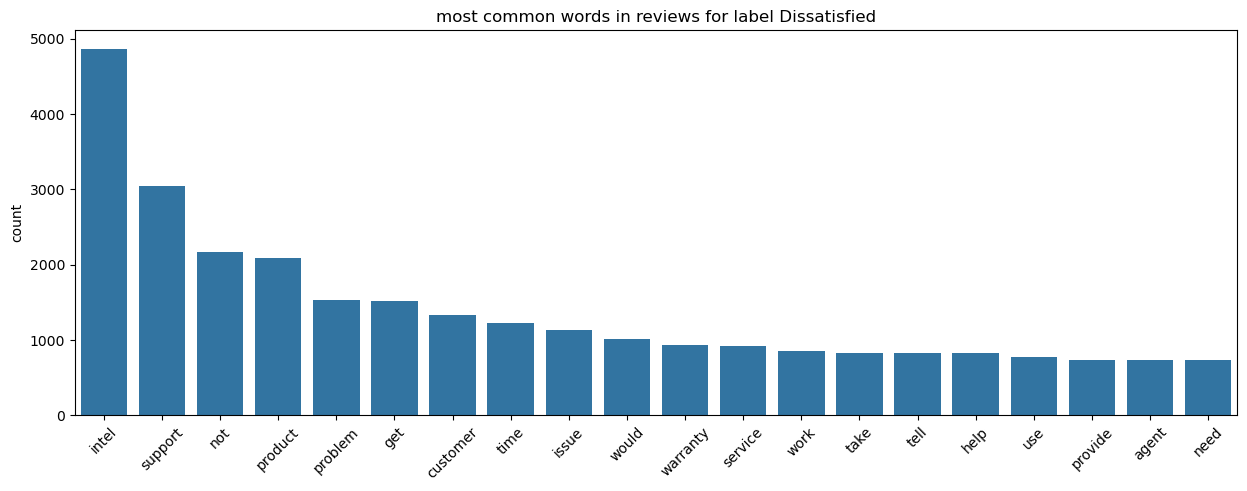

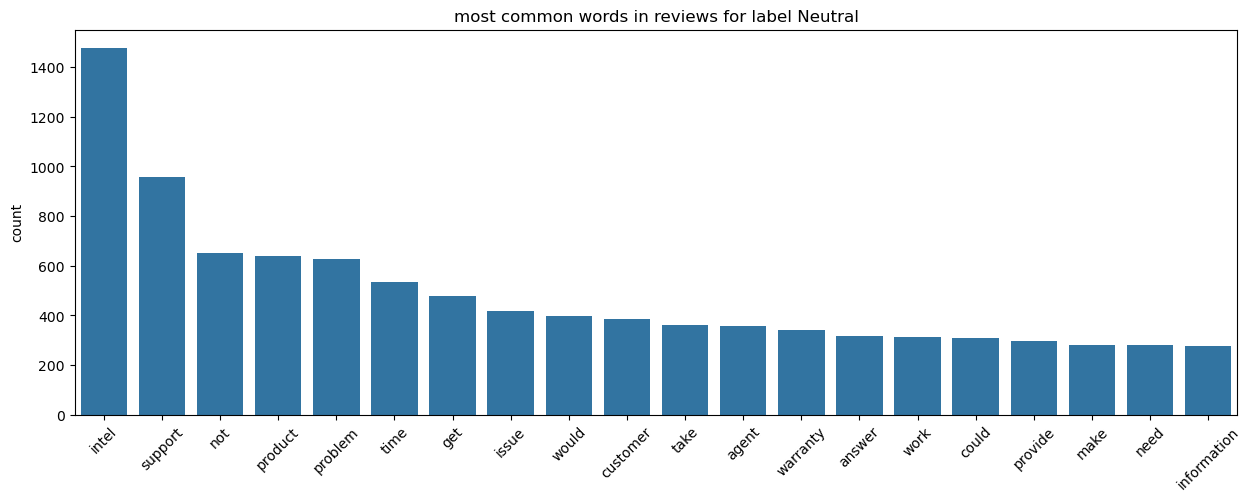

In [32]:
satification_list = processed_df['SAT'].unique()

for satisfaction in satification_list:   
    sat_df = processed_df.loc[(processed_df['SAT'] == satisfaction)]
    all_words = " ".join(sat_df["processed_MTranslation2"]).split()
    word_freq = Counter(all_words)
    common_words = word_freq.most_common(20)

    plt.figure(figsize=(15,5))
    sns.barplot(x=[word[0] for word in common_words], y=[word[1] for word in common_words])
    plt.xticks(rotation=45)
    plt.ylabel("count")
    plt.title(f"most common words in reviews for label {satisfaction}")
    plt.show()

## Word Frequency 

### Key Observations

When visualizing the most frequently used words among satisfied, neutral, and dissatisfied customers, there appears to be significant overlap. Many of the same words appear across all three categories, suggesting that sentiment may be influenced more by context rather than individual word frequency alone.

Considering the high word overlap, TF-IDF vectorization is generally more effective than CountVectorizer. TF-IDF assigns greater weight to rare words while downweighting common words, making it better for distinguishing important terms in text classification and NLP tasks.

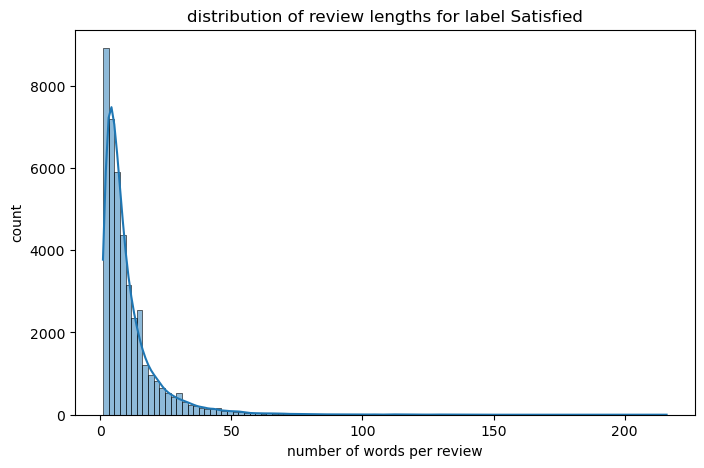

count    41761.000000
mean        10.700869
std         11.809835
min          1.000000
25%          4.000000
50%          7.000000
75%         13.000000
max        216.000000
Name: review_length, dtype: float64




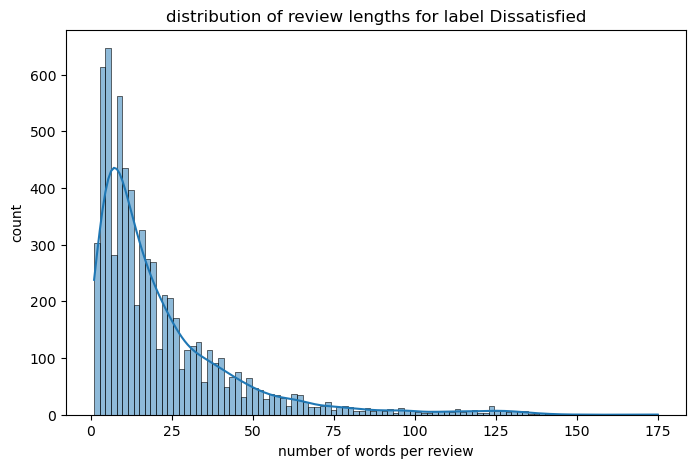

count    6766.000000
mean       21.968519
std        22.902571
min         1.000000
25%         7.000000
50%        14.000000
75%        28.000000
max       175.000000
Name: review_length, dtype: float64




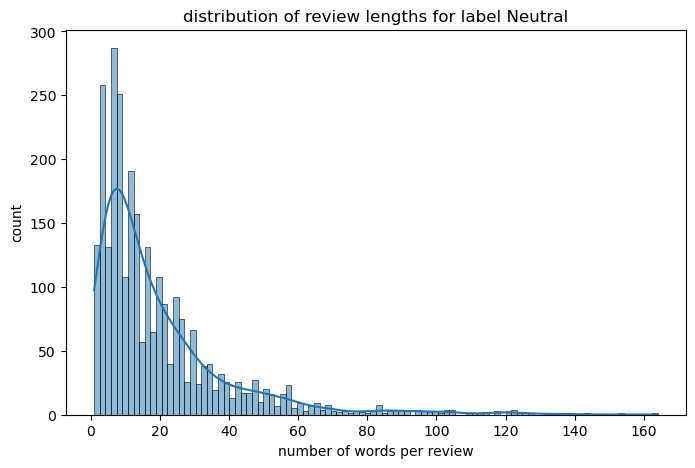

count    2766.000000
mean       19.623283
std        20.387862
min         1.000000
25%         7.000000
50%        13.000000
75%        25.000000
max       164.000000
Name: review_length, dtype: float64




In [35]:
satification_list = processed_df['SAT'].unique()
for satisfaction in satification_list:
    sat_df = processed_df.loc[(processed_df['SAT'] == satisfaction)]
    
    plt.figure(figsize=(8,5))
    sns.histplot(sat_df["review_length"], bins=100, kde=True)
    plt.xlabel("number of words per review")
    plt.ylabel("count")
    plt.title(f"distribution of review lengths for label {satisfaction}")
    plt.show()

    print(sat_df['review_length'].describe())
    print('\n')

## Review Length Analysis by Satisfaction Level  

### Key Observations

When analyzing the distribution of review lengths across satisfaction levels, a clear pattern emerges: **satisfied customers tend to be more short with their reviews**.  

- **Satisfied customers** leave reviews with a mean length of just 11 words and a standard deviation of 12.  
- **Neutral customers** have an average review length of 20 words and a standard deviation of 20.  
- **Dissatisfied customers** tend to provide the longest feedback, averaging 22 words and a standard deviation of 23.  

This suggests that **dissatisfaction often leads to more detailed feedback**, while satisfaction is expressed more briefly.

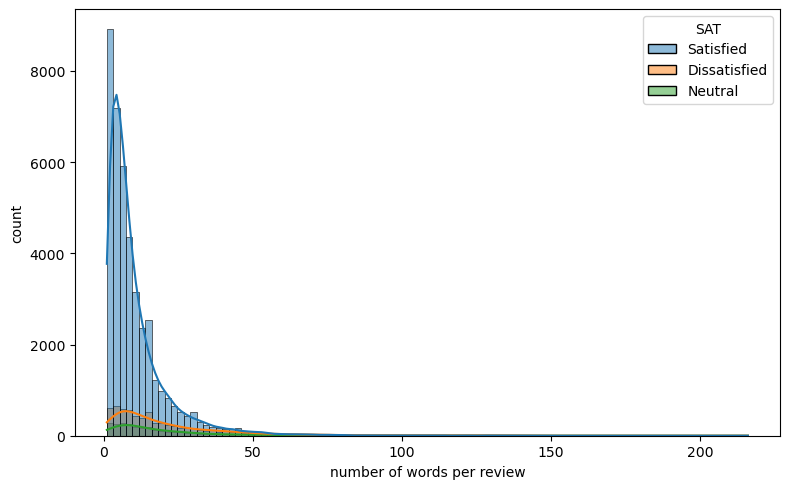

In [38]:
plt.figure(figsize=(8,5))
sns.histplot(data=processed_df, x='review_length', hue='SAT', bins=100, kde=True)
plt.xlabel("number of words per review")
plt.ylabel("count")
plt.tight_layout()
plt.show()

In [40]:
satisfied = processed_df.loc[processed_df['SAT'] == 'Satisfied', 'review_length']
not_satisfied = processed_df.loc[
    (processed_df['SAT'] == 'Dissatisfied') | (processed_df['SAT'] == 'Neutral'), 
    'review_length'
]

print('\n')
print(stats.ttest_ind(satisfied, not_satisfied))
print('\n')



TtestResult(statistic=-65.08371363729768, pvalue=0.0, df=51291.0)




## Review Length T-Test  

### Key Observations  

#### Null Hypothesis (H₀)  
There is no significant difference in review length between satisfied customers and other satisfaction groups (dissatisfied & neutral).  

#### Alternative Hypothesis (H₁)  
There is a significant difference in review length between satisfied customers and other satisfaction groups, suggesting that review length may serve as an indicator of customer sentiment.

With a p-value of <0.05, we have sufficient statistical evidence to conclude that there is a significant difference in the mean review lengths between satisfied customers and other satisfaction groups.

In [43]:
processed_df['SAT_Target'] = processed_df['SAT'].astype('category').cat.codes

processed_df.info()
processed_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51293 entries, 0 to 51292
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   SAT                      51293 non-null  object
 1   MTranslation2            51293 non-null  object
 2   processed_MTranslation2  51293 non-null  object
 3   review_length            51293 non-null  int64 
 4   SAT_Target               51293 non-null  int8  
dtypes: int64(1), int8(1), object(3)
memory usage: 1.6+ MB


,SAT,MTranslation2,processed_MTranslation2,review_length,SAT_Target
0,Satisfied,"they were persistent in achieving the task, wh...",persistent achieve task helpfuleven busy sched...,13,2
1,Satisfied,Hope to print After-sale service information o...,hope print aftersale service information product,6,2
2,Satisfied,Our support staff was very courteous. The with...,support staff courteous withdrawal defective o...,30,2


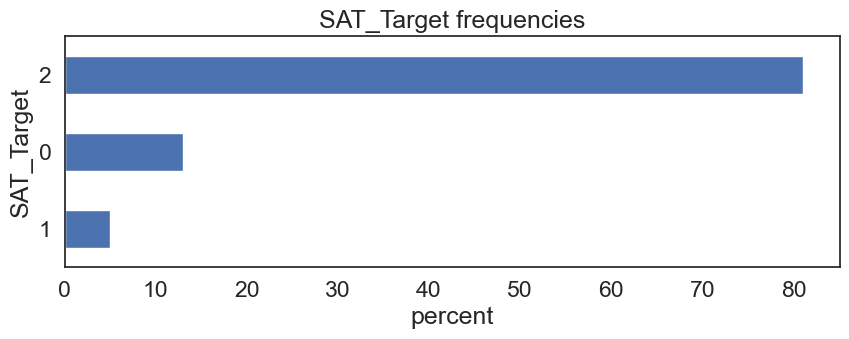

Counts
SAT_Target
2             41761
0              6766
1              2766
Name: count, dtype: int64


Percentages
SAT_Target
2             81.416568
0             13.190884
1              5.392549
Name: proportion, dtype: float64


In [45]:
# Retaine missed_playoffs in a separate data frame
target_df = processed_df[['SAT_Target']].astype(str)

# Satisfaction frequencies
Preprocessing.cat_univariate_freq(
    df = target_df, 
    length = 3, 
    width = 10, 
    col_start = 0, 
    col_end = 1, 
    font = 1.5
)

# Calculate the averages accross both classifications
print('Counts')
print(target_df.value_counts())
print('\n')
print('Percentages')
print(target_df.value_counts(normalize=True) * 100)

In [47]:
processed_df.to_csv('Preprocessed_Data/Preprocessed_Data.csv', index=False)

## Satisfaction Frequencies

### Key Observations

The data set when split between the different satisfaction groups is significantly imbalanced. Addressing this imbalance will be a key focus in delivering a reliable classification model.

* **Satisfied (2):** 81% of the total data
* **Dissatisfied (0):** 13% of the total data
* **Neutral (1):** 5% of the total data